Curtis Sera <br>
v2.0.5 <br>
2020-11-06

# Protrusion cap: before and after fusion

Adapted from BaseFusionPrePost.ipynb v1.1.1

## Introduction
This is a simple comparison of the bending energies for a fusion event occuring in the <i>Bt</i> protrusion cap.  Starting with the protrusion set-up shown on the left and ending with the geometry shown in C:
<img src="Imgs/protr_fusion_routes.jpg" width=600 /><br>

We will again split the protrusion into three idealized sections: toroidal base, cylindrical body, hemispherical cap.  We will further make the simplifying assumptions that only the toroidal base has changed geometry (perhaps this is very shortly after fusion) and that any excess membrane has been able to flow into a stress-free bulk.  Thus, our expression for the change in bending energy is simply:

$\Delta G = (G_{pore} + G_{cap rim} ) - G_{hemipsherical cap}$

That is, within this model we don't need to pay attention to anything other than the cap and what it turns into.

## Set-up
To get started, let's first set our key system properties.  We'll be using the same variable names as in FusionPoreExpanG.ipynb.

We will make the rim toroidal (the top of a donut), and $r_{t,rim}$ will be the intermembrane distance.  Two intermembrane distance will span 25 nm which is what I measured from 2019-08-05's infected-0040.tif and which is ~consistent with the known ER intermembrane distance of 30 nm.

In [19]:
import numpy as np
import plotly.graph_objs as go

# Membrane properties
Kb = 15         # kT

# Pre-fusion properties
R0 = 375        # nm

# Post-fusion properties
rim_rt = np.array([2,2.3,2.6,3,3.5,4,5,6.5,8,10,
                   12.5,15,17.5,20,22.5,25,30,35,40,45])    # nm
    # the intermembrane distance of the residual protrusion
    # (ie toroidal rim's tube radius)

def helfrichStress(k1,k2,Kb):
    '''
    Helfrich bending *stress*
    
    Args:
        k1 (float): Principal curvature 1; 1/nm
        k2 (float): Principal curvature 2; 1/nm
        Kb (float): Helfrich bending constant for membrane; kT/nm^2
    Returns:
        float: The Helfrich bending *stress* (ie energy for an infinitesimal dA) 
    '''
    return 0.5*Kb*(k1+k2)**2 # Note units = energy/unit area = kT/nm^2

def torusCircCurv(R,r,u):
    '''
    Curvature (reciprocal of radius of curvature) on a torus at a point defined by the angle u due 
    to connecting the tube ends.  The "circumferential curvature".
    
    Args:
        R (float): distance from torus center to inner wall; nm
        r (float): torus tube radius; nm
        u (float): angle giving location on the relevant slice of tube where 0 points transversely *out*; radians
    Returns:
        float: Circumferential curvature; 1/nm
    '''
    return (np.cos(u)) / (R + r + r*np.cos(u));

def GToroidalPore(R,r,Kb):
    '''
    Bending energy for a toroidal pore *with no spontaneous curvature*.
    
    Args:
        R (float): distance from torus center to inner wall; nm
        r (float): torus tube radius; nm
        Kb (float): Helfrich bending constant for membrane; kT/nm^2
    Returns:
        float: Pore bending energy; kT
    '''
    return Kb*np.pi*2* ( np.arctan(np.sqrt((r+2*R)/r)) * (2*(r+R)**2)/(R*np.sqrt(r**2+2*R*r)) - 4 );

## Computation: pre-fusion cap

Given that the cap is hemispherical, we know that the stress is uniform everywhere in it so we only need to find $G_b$ per unit area then multiply by the cap's area

In [20]:
preStress = helfrichStress(1/R0,1/R0,2*Kb) # 2*Kb since two bilayers

ACap = 2*np.pi*(R0**2)

GPre = preStress * ACap

print('ACap = ',ACap,' nm^2')
print("Total Gb of pre-fusion base = ",GPre," kT")

ACap =  883572.9338221293  nm^2
Total Gb of pre-fusion base =  376.99111843077515  kT


Validation of my "simulation parameter" validation:
- Dividing the z axis in to 1+Rt*n steps.  Choosing n=4 appears to be quite sufficient.  The final figure for GPre changes only slightly for n=2-->4, and there is no meaningful difference from n=4-->1000
    - Pass!

## Computation: post-fusion base rim via z-axis Riemann sum in cylindrical coordinates

This is the same as in BaseFusionPrePost.ipynb v1.1.1

*Caution: It is tempting to apply Christoph and Rob's (2011 paper) solution for conical pores to this situation.  However, we cannot.  Their conical set-up requires an imagined vertex that the membrane would converge to.  On the other hand, my cylindrical set-up is at a 90 degree rotation (where 0 is a perfectly flat membrane) and would only have such a vertex if the tube radius was infinitely thin.  We must therefore calculate this via direct application of toroidal geometry.*

This method poses the problem that each location on the z axis corresponds to 2 angles (except at the end).  However, we can use the same trigonometric method that we used in the previous section:

$u_{rim} = \left\{ \pi - arcsin \left(\frac{R_t - z}{R_t} \right) \cup arcsin \left(\frac{R_t - z}{R_t} \right) \right\}$

Note that this will double-count $u_{rim} = \pi/2$, but that shouldn't be a huge problem since its contribution will be small compared to the whole.

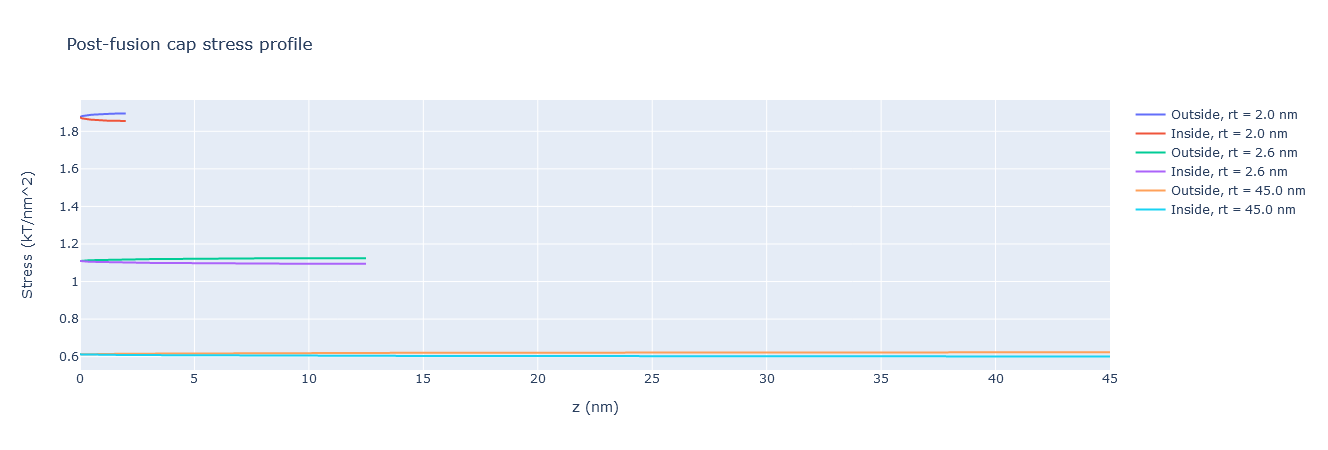

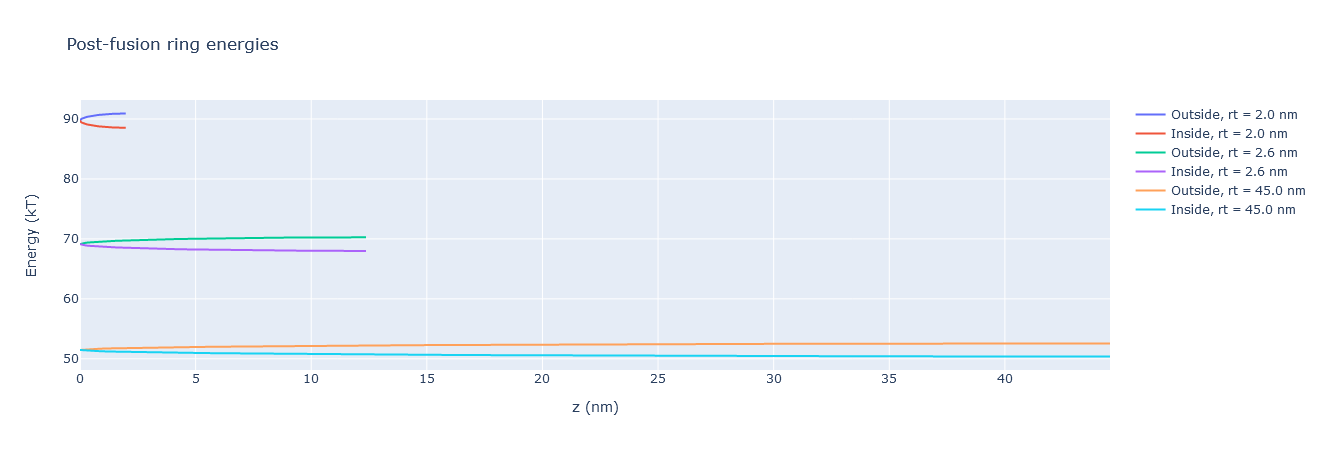

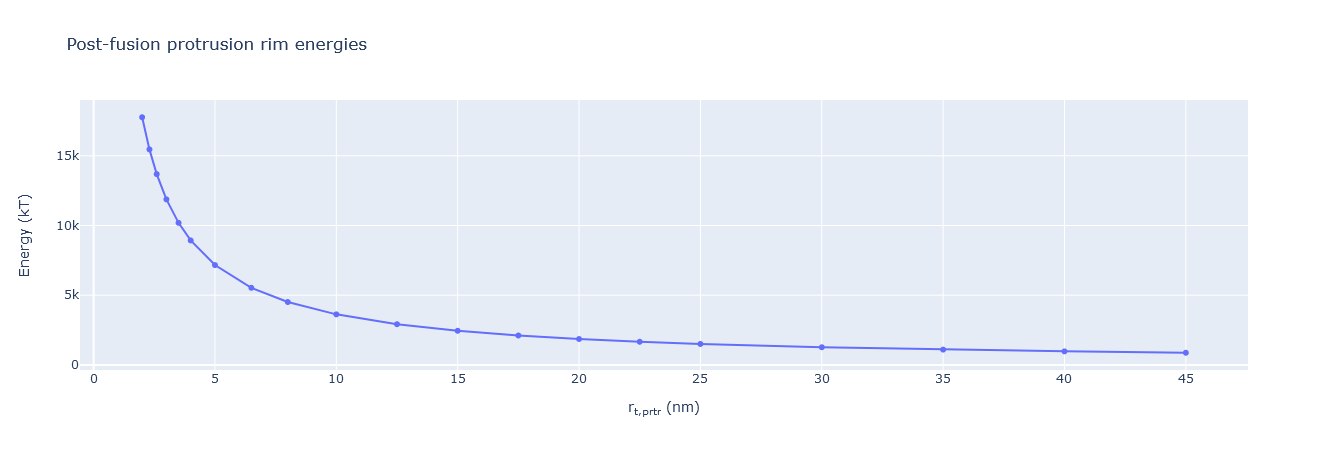

Total Gb of post-fusion protrusion rim in kT =  [17765.70646348 15460.68401717 13687.57846712 11875.05529713
 10191.97709488  8929.64813019  7162.33909324  5530.88442417
  4511.13607392  3627.24471603  2919.99324429  2448.36663786
  2111.38509444  1858.558692    1661.83745468  1504.39137924
  1268.05463103  1099.05820953   972.15681105   873.32510288]


In [21]:
zSteps = 100
zRim = [np.linspace(0,rim_rt[0],num=zSteps)] # nm
for rt in range(1,rim_rt.size):
    zRim.append(np.linspace(0,rim_rt[rt],num=zSteps))

uRim = np.zeros((rim_rt.size,zSteps,2)) # radians
    # rim tube angle for each rim_rt as a function of z where uRim1 = 0 is 
    # defined as pointing outward on the bisecting transverse plane
    # 3rd dimension to acct for the fact that each z has a u for the inner 
    # surface and a u for the outer surface

kRim = np.zeros((rim_rt.size,zSteps,2)) # 1/nm; curv for each angle u on rim
    # curvature for each rim_rt value at each zRim along the rim surface
stressRim = np.zeros((rim_rt.size,zSteps,2)) # kT/nm^2; stress at each point
GRingPost = np.zeros((rim_rt.size,zSteps-1,2)) # kT; G_b of each ring
    # zRim.size-1 since Reimann summing reduces num of elements by 1
GPost = np.zeros(rim_rt.size)

#First calculate the relevant angles
for rt in range(0,rim_rt.size):
    for z in range(0,zSteps):
        uRim[rt,z,0] = np.arcsin((rim_rt[rt]-zRim[rt][z])/rim_rt[rt])  # Outside of torus
        uRim[rt,z,1] = np.pi - np.arcsin((rim_rt[rt]-zRim[rt][z])/rim_rt[rt])  # Inside of torus
        
#Second calculate the curvatures
for rt in range(0,rim_rt.size):
    for z in range(0,zSteps):
        kRim[rt,z,0] = torusCircCurv(R0,rim_rt[rt],uRim[rt,z,0])
        kRim[rt,z,1] = torusCircCurv(R0,rim_rt[rt],uRim[rt,z,1])
#print(kRim)

#Next calculate the "stress" (energy per unit area) profile
for rt in range(0,rim_rt.size):
    for z in range(0,zSteps):
        stressRim[rt,z,0] = helfrichStress(kRim[rt,z,0],1/rim_rt[rt],Kb)
        stressRim[rt,z,1] = helfrichStress(kRim[rt,z,1],1/rim_rt[rt],Kb)
            # NOT Kb*2 since only a single bilayer bending now

# Now find the energy of the discrete uRim rings via left Riemann sum
# To do so, we first must find the radii of the inner ringers and the outer rings
R1Out = np.zeros((rim_rt.size,zSteps))
R1In = np.zeros((rim_rt.size,zSteps))
for rt in range(0,rim_rt.size):
    for z in range(0,zSteps):
        R1Out[rt,z] = R0 + rim_rt[rt] + np.sqrt(1-((rim_rt[rt]-zRim[rt][z])/rim_rt[rt])**2) #out
        R1In[rt,z] = R0 + rim_rt[rt] - np.sqrt(1-((rim_rt[rt]-zRim[rt][z])/rim_rt[rt])**2) #in
            #Dist from z axis to membrane at given z (using trig a identity)
# Now we'll find the energy of each ring via left Riemann sum
for rt in range(0,rim_rt.size):
    for z in range(0,zSteps-1):
        # Stress per ring by finding cylindrical wall area * ring stress
        GRingPost[rt,z,0] = np.pi * 2*R1Out[rt,z] * (zRim[rt][1]-zRim[rt][0]) * stressRim[rt,z,0]
        GRingPost[rt,z,1] = np.pi * 2*R1In[rt,z] * (zRim[rt][1]-zRim[rt][0]) * stressRim[rt,z,1]

# Finally, add up all the rings' energies to get the total energy
for rt in range(0,rim_rt.size):
    for z in range(0,zSteps-1):
        GPost[rt] += GRingPost[rt,z,0] + GRingPost[rt,z,1]

#--------------------------------------------------------------------------------------------
# Graph the results
#--------------------------------------------------------------------------------------------
stressPlot = go.Figure()
stressPlot.add_trace(go.Scatter(x=zRim[0], y=stressRim[0,:,0], mode='lines', 
                                name='Outside, rt = {0} nm'.format(rim_rt[0])))
stressPlot.add_trace(go.Scatter(x=zRim[0], y=stressRim[0,:,1], mode='lines', 
                                name='Inside, rt = {0} nm'.format(rim_rt[0])))
stressPlot.add_trace(go.Scatter(x=zRim[round((rim_rt.size-1)/2)], y=stressRim[2,:,0], mode='lines', 
                                name='Outside, rt = {0} nm'.format(rim_rt[2])))
stressPlot.add_trace(go.Scatter(x=zRim[round((rim_rt.size-1)/2)], y=stressRim[2,:,1], mode='lines', 
                                name='Inside, rt = {0} nm'.format(rim_rt[2])))
stressPlot.add_trace(go.Scatter(x=zRim[rim_rt.size-1], y=stressRim[4,:,0], mode='lines', 
                                name='Outside, rt = {0} nm'.format(rim_rt[rim_rt.size-1])))
stressPlot.add_trace(go.Scatter(x=zRim[rim_rt.size-1], y=stressRim[4,:,1], mode='lines', 
                                name='Inside, rt = {0} nm'.format(rim_rt[rim_rt.size-1])))
stressPlot.update_layout(title="Post-fusion cap stress profile",
                        xaxis_title="z (nm)", yaxis_title="Stress (kT/nm^2)")
stressPlot.show()

ringGPlot = go.Figure()
ringGPlot.add_trace(go.Scatter(x=zRim[0], y=GRingPost[0,:,0], mode='lines', 
                               name='Outside, rt = {0} nm'.format(rim_rt[0])))
ringGPlot.add_trace(go.Scatter(x=zRim[0], y=GRingPost[0,:,1], mode='lines', 
                               name='Inside, rt = {0} nm'.format(rim_rt[0])))
ringGPlot.add_trace(go.Scatter(x=zRim[round((rim_rt.size-1)/2)], y=GRingPost[2,:,0], mode='lines', 
                               name='Outside, rt = {0} nm'.format(rim_rt[2])))
ringGPlot.add_trace(go.Scatter(x=zRim[round((rim_rt.size-1)/2)], y=GRingPost[2,:,1], mode='lines', 
                               name='Inside, rt = {0} nm'.format(rim_rt[2])))
ringGPlot.add_trace(go.Scatter(x=zRim[rim_rt.size-1], y=GRingPost[4,:,0], mode='lines', 
                               name='Outside, rt = {0} nm'.format(rim_rt[rim_rt.size-1])))
ringGPlot.add_trace(go.Scatter(x=zRim[rim_rt.size-1], y=GRingPost[4,:,1], mode='lines', 
                               name='Inside, rt = {0} nm'.format(rim_rt[rim_rt.size-1])))
ringGPlot.update_layout(title="Post-fusion ring energies",
                        xaxis_title="z (nm)", yaxis_title="Energy (kT)")
ringGPlot.show()

postGPlot = go.Figure()
postGPlot.add_trace(go.Scatter(x=rim_rt, y=GPost, mode='markers + lines'))
postGPlot.update_layout(title="Post-fusion protrusion rim energies",
                        xaxis_title="r<sub>t,prtr</sub> (nm)", yaxis_title="Energy (kT)")
postGPlot.show()

print("Total Gb of post-fusion protrusion rim in kT = ",GPost)

"Simulation parameter" validation: 
- Logical trend in GPost1: PASS
- zRim values match desired values: PASS
- Sufficient z resolution: PASS
    - Each of the GPost1 change by less than 1 kT when increasing zSteps from 100 --> 1000

## Comparing pre-fusion energy vs post-fusion energy

Some relevant pore energies below.
Note that these numbers should not be taken at face-value since the hypothetical pores are huge.
Pore Gb for pore radius 400 nm, pore_rt = 15:  3569.3455980891786
Pore Gb for pore radius 400 nm, pore_rt = 25:  2090.8478991057846
Pore Gb for pore radius 400 nm, pore_rt = 50:  985.3105416057647
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


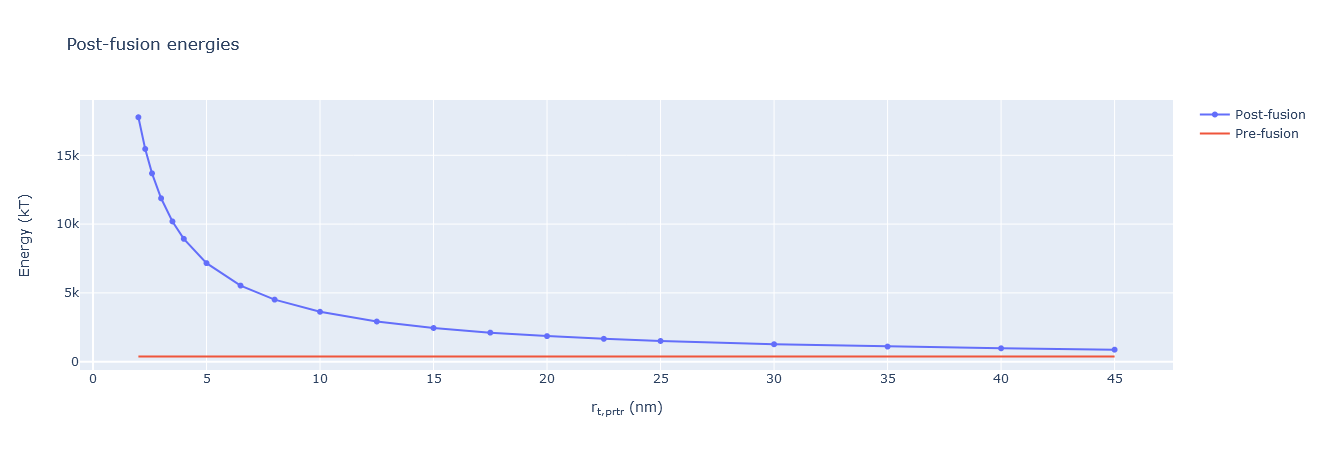

In [22]:
print("Some relevant pore energies below.")
print("Note that these numbers should not be taken at face-value since the hypothetical pores are huge.")
print("Pore Gb for pore radius 400 nm, pore_rt = 15: ",GToroidalPore(15,R0,Kb))
print("Pore Gb for pore radius 400 nm, pore_rt = 25: ",GToroidalPore(25,R0,Kb))
print("Pore Gb for pore radius 400 nm, pore_rt = 50: ",GToroidalPore(50,R0,Kb))

GPreArr = np.zeros(np.amax(rim_rt).astype(int)) # np.amax() yields a numpy float so cast to int
print(GPreArr)
for a in range(0,GPreArr.size):
    GPreArr[a] = GPre

vsPlot = go.Figure()
vsPlot.add_trace(go.Scatter(x=rim_rt, y=GPost, mode='markers + lines', name='Post-fusion'))
vsPlot.add_trace(go.Scatter(x=rim_rt, y=GPreArr, mode='lines', name='Pre-fusion'))
vsPlot.update_layout(title="Post-fusion energies",
                        xaxis_title="r<sub>t,prtr</sub> (nm)", yaxis_title="Energy (kT)")
vsPlot.show()

If this is accurate, the energetic increase may decrease with greater $r_{t,rim}$, but fusion at the base is clearly an energy *intensive* process, not one that releases energy.

## Calculate pre vs post $G_b$ difference and export results

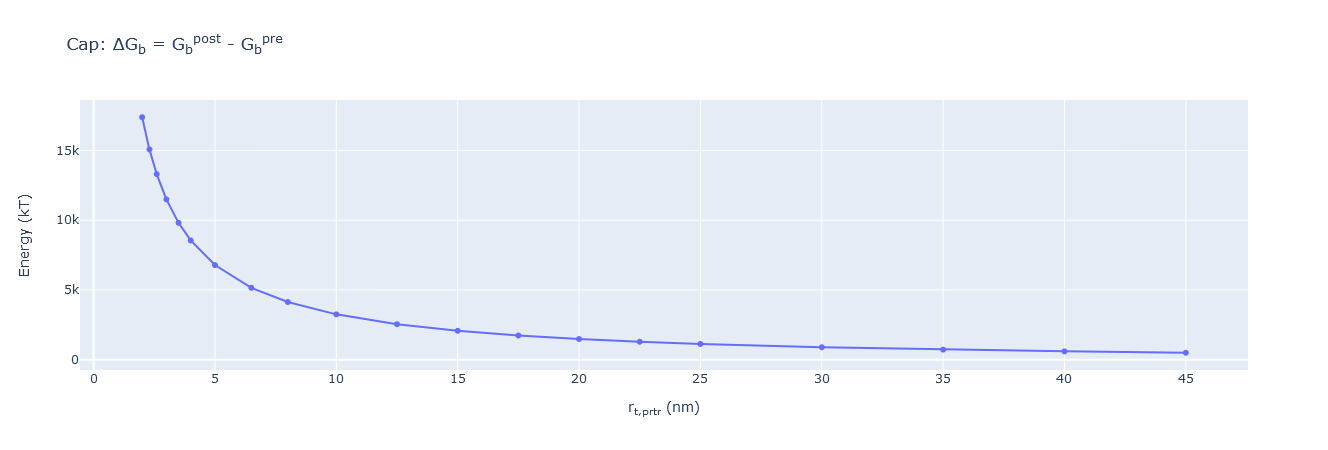

Saving DGb for cap
Saving rim_rt for cap
Done!


In [23]:
DGb = GPost - GPre

DGbPlot = go.Figure()
DGbPlot.add_trace(go.Scatter(x=rim_rt, y=DGb, mode='markers + lines'))
DGbPlot.update_layout(title="Cap: ΔG<sub>b</sub> = G<sub>b</sub><sup>post</sup> - G<sub>b</sub><sup>pre</sup>",
                        xaxis_title="r<sub>t,prtr</sub> (nm)", yaxis_title="Energy (kT)")
DGbPlot.show()

print('Saving DGb for cap')
np.savetxt('output data/Cap DGb 2-0.csv', DGb, delimiter=',') # Export DGb as a versioned csv
print('Saving rim_rt for cap')
np.savetxt('output data/Cap rt 2-0.csv', rim_rt, delimiter=',') # Export rim_rt that was used
print('Done!')

In [24]:
DGbPlot.write_image("output data/Cap DGb 2-0-5.pdf")